## Imports

In [1]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from glob import glob
from pandas.api.types import is_numeric_dtype

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from typing import Dict, List
from tabulate import tabulate

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Data Reading and Preparation

### Read Data

In [2]:
data_raw = pd.read_excel('vitrina_clients_vkr.xlsx')

### Preparation For Analysis

In [3]:
# data_raw.set_index('client_id', inplace=True)

In [4]:
data_raw.head(5)

,client_id,DistinctCountOrders,AverageOrderSum,AvgBill,AverageNumItemsInOrder,RevenueClient,TotalNumberItemsOrdered,AverageMarginOrder,cnt_purchased_orders,AvgOrderSumPurchased,...,КГТ,ОДЕЖДА,ППКП,CENTRAL,FAR EAST,NORTH,PRIVOLZIE,SIBERIA,SOUTHERN,URAL
0,55575053-54505550565678,100,1758.900000,1722.800000,2.440000,172280.0,244,219.014700,80,1574.750000,...,0.192623,0.639344,0.024590,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55575048-48524956565375,66,580.318182,524.212121,3.787879,34598.0,250,144.108615,60,542.216667,...,0.012000,0.320000,0.460000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,55575555-57524953505673,54,823.166667,806.925926,2.703704,43574.0,146,95.811296,53,816.169811,...,0.000000,0.952055,0.006849,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55574953-50505150484978,59,3608.406780,3482.881356,4.169492,205490.0,246,429.037119,45,3217.244444,...,0.186992,0.569106,0.105691,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,55575054-51515151484875,46,2669.847826,2632.239130,1.717391,121083.0,79,310.657174,40,2689.475000,...,0.455696,0.405063,0.088608,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data_raw.describe()

,DistinctCountOrders,AverageOrderSum,AvgBill,AverageNumItemsInOrder,RevenueClient,TotalNumberItemsOrdered,AverageMarginOrder,cnt_purchased_orders,AvgOrderSumPurchased,AvgNumItemsOrderPurchased,...,КГТ,ОДЕЖДА,ППКП,CENTRAL,FAR EAST,NORTH,PRIVOLZIE,SIBERIA,SOUTHERN,URAL
count,194005.000000,194005.000000,194005.000000,194005.000000,1.940050e+05,194005.000000,193541.000000,194005.000000,104284.000000,104284.000000,...,194005.000000,194005.000000,194005.000000,194005.000000,194005.000000,194005.000000,194005.000000,194005.000000,194005.000000,194005.000000
mean,1.770893,3757.176754,3409.756718,4.521722,5.586925e+03,9.537326,884.237332,0.779836,3405.628582,3.649265,...,0.189299,0.201017,0.311668,0.599398,0.004767,0.091474,0.139110,0.054599,0.056893,0.053759
std,1.974436,5073.956390,4954.154770,9.586300,9.740337e+03,27.380757,1652.670764,1.173811,4592.510024,6.837184,...,0.371998,0.364610,0.424662,0.489680,0.068770,0.288102,0.345804,0.227063,0.231375,0.225349
min,1.000000,1.000000,1.000000,0.166667,1.000000e+00,1.000000,-127361.010000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1303.000000,1085.000000,1.000000,1.308000e+03,1.000000,152.945000,0.000000,1190.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2319.000000,1999.000000,2.000000,2.772000e+03,2.000000,411.045000,1.000000,2100.000000,2.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,4085.000000,3610.000000,4.000000,6.017000e+03,7.000000,992.740000,1.000000,3565.000000,4.000000,...,0.047619,0.200000,0.800000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,115.000000,200449.000000,166938.000000,559.000000,1.117812e+06,1363.000000,52965.000000,80.000000,121955.000000,559.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Removing correlation

In [6]:
corr = data_raw.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,DistinctCountOrders,AverageOrderSum,AvgBill,AverageNumItemsInOrder,RevenueClient,TotalNumberItemsOrdered,AverageMarginOrder,cnt_purchased_orders,AvgOrderSumPurchased,AvgNumItemsOrderPurchased,RevenueClientPurchased,PurchasedItems,AvgMarginPurchased,SharePurchasedOrders,ДЕТСКОЕ ПИТАНИЕ,ЖЕНСКИЕ ШТУЧКИ,ИГРУШКИ,"КАНЦТОВАРЫ, КНИГИ, ДИСКИ",КОСМЕТИКА/ГИГИЕНА,КРУПНОГАБАРИТНЫЙ ТОВАР,ОБУВЬ,ПОДГУЗНИКИ,СОПУТСТВУЮЩИЕ ТОВАРЫ,"ТЕКСТИЛЬ, ТРИКОТАЖ",ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА,ТОВАРЫ ДЛЯ ЖИВОТНЫХ,ТОВАРЫ ДЛЯ КОРМЛЕНИЯ,ИГРУШКИ.1,ИНОЕ,КГТ,ОДЕЖДА,ППКП,CENTRAL,FAR EAST,NORTH,PRIVOLZIE,SIBERIA,SOUTHERN,URAL
DistinctCountOrders,1.00,0.03,0.01,0.26,0.48,0.60,-0.03,0.36,0.03,0.31,0.29,0.50,-0.05,-0.03,0.27,0.07,0.01,0.15,0.24,0.00,0.13,0.28,0.08,0.21,0.03,0.08,0.21,0.00,0.10,0.00,0.17,0.24,-0.03,0.02,-0.03,0.04,0.01,0.01,0.00
AverageOrderSum,0.03,1.00,0.93,0.20,0.81,0.17,0.71,-0.10,0.95,0.09,0.81,0.08,0.65,-0.12,0.05,0.03,-0.16,-0.01,0.05,0.39,0.01,0.03,0.01,0.05,0.00,-0.00,0.02,-0.18,0.01,0.39,0.01,-0.07,0.06,0.01,-0.04,-0.08,0.00,0.02,0.01
AvgBill,0.01,0.93,1.00,0.07,0.85,0.06,0.76,-0.08,0.89,-0.02,0.85,-0.03,0.69,-0.08,-0.10,0.03,-0.09,-0.00,0.02,0.44,0.04,-0.05,0.01,0.10,0.00,-0.01,0.02,-0.11,-0.00,0.44,0.08,-0.22,0.06,0.00,-0.05,-0.06,0.00,0.02,0.01
AverageNumItemsInOrder,0.26,0.20,0.07,1.00,0.18,0.91,0.05,0.03,0.08,0.94,0.09,0.89,-0.04,-0.09,0.45,0.09,0.01,0.22,0.39,-0.24,0.09,0.28,0.08,0.24,0.03,0.09,0.27,0.01,0.12,-0.24,0.19,0.41,0.15,0.02,-0.05,-0.08,-0.05,-0.03,-0.06
RevenueClient,0.48,0.81,0.85,0.18,1.00,0.34,0.63,0.13,0.75,0.14,0.88,0.25,0.55,-0.08,0.05,0.06,-0.09,0.07,0.14,0.39,0.10,0.10,0.05,0.18,0.02,0.03,0.12,-0.10,0.05,0.39,0.14,-0.07,0.03,0.02,-0.06,-0.03,0.01,0.03,0.01
TotalNumberItemsOrdered,0.60,0.17,0.06,0.91,0.34,1.00,0.03,0.16,0.08,0.85,0.20,0.90,-0.05,-0.09,0.47,0.09,0.00,0.23,0.40,-0.19,0.13,0.34,0.09,0.27,0.03,0.10,0.29,0.01,0.13,-0.19,0.22,0.43,0.11,0.02,-0.05,-0.04,-0.03,-0.02,-0.04
AverageMarginOrder,-0.03,0.71,0.76,0.05,0.63,0.03,1.00,-0.10,0.65,-0.03,0.61,-0.05,0.95,-0.09,-0.17,0.02,-0.14,0.02,-0.04,0.51,0.14,-0.27,0.02,0.20,0.00,-0.08,-0.04,-0.15,-0.06,0.51,0.23,-0.39,0.07,-0.01,-0.04,-0.06,-0.01,0.01,0.00
cnt_purchased_orders,0.36,-0.10,-0.08,0.03,0.13,0.16,-0.10,1.00,0.03,0.31,0.40,0.58,-0.05,0.87,0.00,0.03,0.04,0.07,0.09,0.03,-0.01,0.12,0.03,0.05,0.01,0.06,0.10,0.04,0.06,0.03,0.00,0.07,-0.06,-0.01,-0.03,0.10,-0.01,0.02,0.01
AvgOrderSumPurchased,0.03,0.95,0.89,0.08,0.75,0.08,0.65,0.03,1.00,0.10,0.85,0.09,0.67,-0.02,0.04,0.01,-0.21,-0.05,0.00,0.44,-0.05,0.05,-0.01,-0.00,-0.00,-0.01,-0.01,-0.23,-0.01,0.44,-0.04,-0.06,-0.07,0.03,-0.00,-0.03,0.06,0.07,0.06
AvgNumItemsOrderPurchased,0.31,0.09,-0.02,0.94,0.14,0.85,-0.03,0.31,0.10,1.00,0.10,0.94,-0.03,-0.17,0.40,0.08,0.02,0.22,0.38,-0.24,0.06,0.30,0.08,0.23,0.03,0.09,0.27,0.03,0.12,-0.24,0.18,0.41,0.06,0.01,-0.00,-0.04,-0.03,-0.00,-0.02


##### Normalization

In [7]:
from scipy.stats import norm, shapiro

def scaling_column(column):
    return (column - column.mean()) / column.std()

for col in tqdm(data_raw.columns):
    if is_numeric_dtype(data_raw[col]):
        shapiro_test = shapiro(data_raw[col])
        
        if shapiro_test.pvalue > 0.05:
            print(col)
            data_raw[col] = scaling_column(data_raw[col])
        else:
            data_raw[col] = scaling_column(np.log(data_raw[col] - data_raw[col].min() + 1))

  0%|          | 0/40 [00:00<?, ?it/s]

AverageMarginOrder
AvgOrderSumPurchased
AvgNumItemsOrderPurchased
RevenueClientPurchased
PurchasedItems
AvgMarginPurchased


In [8]:
mask = [not is_numeric_dtype(data_raw[c]) for c in data_raw.columns]
print(f'Founded {sum(mask)} non numeric elements')
data_raw.dtypes[mask]

Founded 1 non numeric elements


client_id    object
dtype: object

In [9]:
cols_with_null = []
for col in data_raw.columns:
    null_count = (data_raw[col].isnull()).sum()
    if null_count != 0:
        print(f'{col}: {null_count}')
        cols_with_null.append(col)

AverageMarginOrder: 464
AvgOrderSumPurchased: 89721
AvgNumItemsOrderPurchased: 89721
RevenueClientPurchased: 89721
PurchasedItems: 89721
AvgMarginPurchased: 89982


In [10]:
len(data_raw), len(data_raw.columns)

(194005, 40)

In [11]:
data = data_raw.drop(cols_with_null, inplace=False, axis=1)
data.head(5)

,client_id,DistinctCountOrders,AverageOrderSum,AvgBill,AverageNumItemsInOrder,RevenueClient,TotalNumberItemsOrdered,cnt_purchased_orders,SharePurchasedOrders,ДЕТСКОЕ ПИТАНИЕ,...,КГТ,ОДЕЖДА,ППКП,CENTRAL,FAR EAST,NORTH,PRIVOLZIE,SIBERIA,SOUTHERN,URAL
0,55575053-54505550565678,7.513895,-0.318094,-0.140594,-0.054776,3.510318,3.452822,8.367691,0.812572,-0.373191,...,0.158267,1.353035,-0.668874,0.817881,-0.069344,-0.317574,-0.402388,-0.240511,-0.245989,-0.238621
1,55575048-48524956565375,6.780582,-1.508432,-1.303669,0.386990,2.140475,3.472299,7.766181,0.997019,1.357515,...,-0.474252,0.511115,0.516944,-1.224329,-0.069344,-0.317574,2.488910,-0.240511,-0.245989,-0.238621
2,55575555-57524953505673,6.426434,-1.133165,-0.882026,0.044480,2.337304,3.041074,7.507633,1.108943,-0.373191,...,-0.520195,2.031445,-0.727359,0.817881,-0.069344,-0.317574,-0.402388,-0.240511,-0.245989,-0.238621
3,55574953-50505150484978,6.582715,0.453278,0.547498,0.488635,3.660736,3.459367,7.167520,0.742691,-0.373191,...,0.140039,1.182873,-0.413799,0.817881,-0.069344,-0.317574,-0.402388,-0.240511,-0.245989,-0.238621
4,55575054-51515151484875,6.143457,0.129901,0.273765,-0.374308,3.209402,2.548672,6.923439,0.931206,-0.240044,...,0.925985,0.753787,-0.465938,0.817881,-0.069344,-0.317574,-0.402388,-0.240511,-0.245989,-0.238621


## Methods Performance

In [12]:
# take little part of data to prepare methods

path_X = Path('./checkpoints/X_eval_perr.csv')

try:
    X = pd.read_csv(path_X)
    
except FileNotFoundError:
    n = 2048 #len(data)
    X = data.sample(n).copy()
    X.drop('client_id', axis=1, inplace=True)

In [13]:
len(X)

2048

In [14]:
X.head(5)

,DistinctCountOrders,AverageOrderSum,AvgBill,AverageNumItemsInOrder,RevenueClient,TotalNumberItemsOrdered,cnt_purchased_orders,SharePurchasedOrders,ДЕТСКОЕ ПИТАНИЕ,ЖЕНСКИЕ ШТУЧКИ,...,КГТ,ОДЕЖДА,ППКП,CENTRAL,FAR EAST,NORTH,PRIVOLZIE,SIBERIA,SOUTHERN,URAL
173884,-0.613427,0.014624,0.182659,-0.239701,-0.137150,-0.398804,-0.953662,-1.015179,-0.373191,-0.041528,...,-0.520195,-0.567711,1.570724,0.817881,-0.069344,-0.317574,-0.402388,-0.240511,-0.245989,-0.238621
77391,1.833141,0.032273,0.178881,0.061139,1.042493,0.967979,0.516618,-0.321304,-0.373191,-0.041528,...,-0.520195,2.125733,-0.750216,0.817881,-0.069344,-0.317574,-0.402388,-0.240511,-0.245989,-0.238621
62710,0.609857,0.412375,0.494476,-0.797363,0.726513,-0.398804,0.516618,0.245634,-0.373191,-0.041528,...,-0.520195,-0.567711,-0.750216,-1.224329,-0.069344,3.152800,-0.402388,-0.240511,-0.245989,-0.238621
100141,-0.613427,0.194331,-0.727622,0.147534,-0.931758,-0.073722,0.516618,1.140195,-0.373191,-0.041528,...,-0.520195,-0.567711,1.570724,0.817881,-0.069344,-0.317574,-0.402388,-0.240511,-0.245989,-0.238621
175395,-0.613427,0.630974,0.799477,0.444482,0.401286,0.156927,-0.953662,-1.015179,-0.373191,-0.041528,...,-0.520195,1.606854,-0.750216,0.817881,-0.069344,-0.317574,-0.402388,-0.240511,-0.245989,-0.238621


In [15]:
# X.to_csv('./checkpoints/X_eval_perr.csv')

### PostProcessing utils: metrics functions

In [16]:
from sklearn import metrics
from termcolor import colored

blue_bold = lambda x: colored(f'{x}', 'blue', attrs=['bold'])
green_bold = lambda x: colored(f'{x}', 'green', attrs=['bold'])

def compute_metrics(X: pd.DataFrame, labels: List, print_metrics: bool = False) -> Dict:
    silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
    calinski_harabasz_score = metrics.calinski_harabasz_score(X, labels)
    davies_bouldin_score = metrics.davies_bouldin_score(X, labels)

    result = dict(
        silhouette_score = silhouette_score,
        calinski_harabasz_score = calinski_harabasz_score,
        davies_bouldin_score = davies_bouldin_score,
    )

    if print_metrics:
        keys = list(result.keys())
        keys.sort()

        headers = [blue_bold('metric'), green_bold('value')]
        table = [[blue_bold(k), f'{result[k]:0.3f}'] for k in keys]

        print(f'number of clusters: {max(labels) + 1}', end='\n\n')
        print(tabulate(table, headers))

    return result


def research(method, hyper_params, X, arange_number_of_clusters):

    result = []
    for number_of_clusters in tqdm(arange_number_of_clusters, desc = f'{method.__class__.__name__}'):

        hyper_params['n_clusters'] = number_of_clusters
        clustering = method(**hyper_params).fit(X)
        labels = clustering.labels_
        m = compute_metrics(X, labels, print_metrics=False)

        result.append(dict(
            metrics = m,
            number_of_clusters = number_of_clusters
            )
        )

    return result


def plot_metrics_from_n_clusters(result: Dict):

    metrics_names = list(result[0]['metrics'].keys())
    metrics_names.sort()

    fig, axs = plt.subplots(1, len(metrics_names), figsize=(5*len(metrics_names), 5))

    for i, m in enumerate(metrics_names):
        metric_from_n = [r['metrics'][m] for r in result]
        ns = [r['number_of_clusters'] for r in result]

        axs[i].plot(ns, metric_from_n, label=f'{m}')
        axs[i].grid()
        axs[i].legend(loc='best')

        axs[i].set_xlabel('number_of_clusters')

    plt.show()
    

### Spectral clustering

In [17]:
from sklearn.cluster import SpectralClustering

In [18]:
hyper_params = {
    'n_clusters' : 4,
    'assign_labels' : 'kmeans' # ‘kmeans’, ‘discretize’
}

In [19]:
clustering = SpectralClustering(
    **hyper_params,
    random_state=0).fit(X)

labels = clustering.labels_

n_clusters_ = hyper_params['n_clusters']

In [20]:
m = compute_metrics(X, labels, print_metrics=True)

number of clusters: 4

metric                     value
-----------------------  -------
calinski_harabasz_score   21.789
davies_bouldin_score       0.193
silhouette_score           0.726


type:   0%|          | 0/3 [00:00<?, ?it/s]

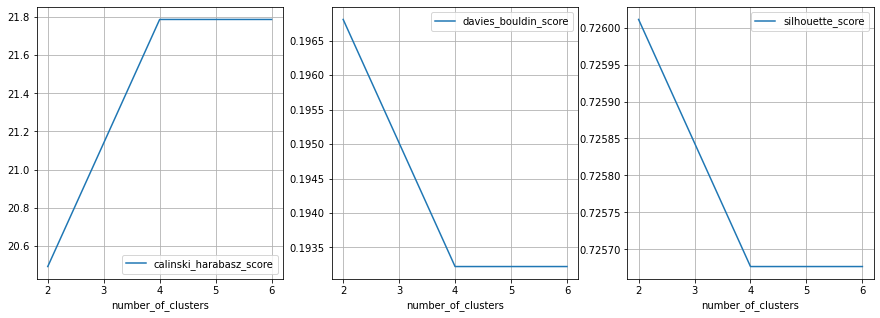

In [21]:
arange_number_of_clusters = [2, 4, 6]
metrics_from_n_clusters = research(SpectralClustering, hyper_params, X, arange_number_of_clusters)
plot_metrics_from_n_clusters(metrics_from_n_clusters)

### Hierarchical clustering

In [24]:
from sklearn.cluster import AgglomerativeClustering

In [25]:
hyper_params = {
    'n_clusters' : 4,
    'linkage' : 'ward' # ‘ward’, ‘complete’, ‘average’, ‘single’
}

In [26]:
clustering = AgglomerativeClustering(**hyper_params).fit(X)

labels = clustering.labels_

n_clusters_ = hyper_params['n_clusters']

In [27]:
m = compute_metrics(X, labels, print_metrics=True)

number of clusters: 4

metric                     value
-----------------------  -------
calinski_harabasz_score  955.741
davies_bouldin_score       0.8
silhouette_score           0.942


type:   0%|          | 0/5 [00:00<?, ?it/s]

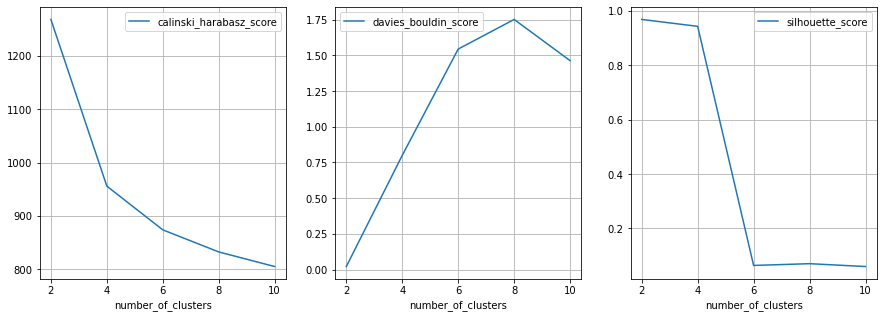

In [28]:
arange_number_of_clusters = [i for i in range(2, 12, 2)]
metrics_from_n_clusters = research(AgglomerativeClustering, hyper_params, X, arange_number_of_clusters)
plot_metrics_from_n_clusters(metrics_from_n_clusters)

### MiniBatchKmeans

In [29]:
from sklearn.cluster import MiniBatchKMeans

In [30]:
hyper_params = dict(
    n_clusters=4
)

In [31]:
clustering = MiniBatchKMeans(**hyper_params).fit(X)

labels = clustering.labels_

In [32]:
m = compute_metrics(X, labels, print_metrics=True)

number of clusters: 4

metric                     value
-----------------------  -------
calinski_harabasz_score  332.491
davies_bouldin_score       3.421
silhouette_score          -0.078


type:   0%|          | 0/5 [00:00<?, ?it/s]

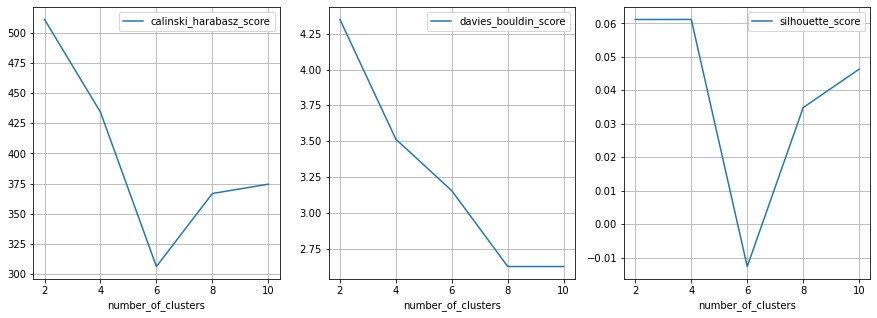

In [33]:
arange_number_of_clusters = [i for i in range(2, 12, 2)]
metrics_from_n_clusters = research(MiniBatchKMeans, hyper_params, X, arange_number_of_clusters)
plot_metrics_from_n_clusters(metrics_from_n_clusters)